In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


Assignment 1

In [ ]:
class GMM:
    """A Gaussian Mixture Model implementation using the Expectation-Maximization algorithm.

    Attributes:
        K (int): Number of Gaussian components.
        max_iter (int): Maximum number of iterations for the EM algorithm.
        tol (float): Convergence tolerance for the log-likelihood.
        weights (ndarray): Mixture weights for each component.
        means (ndarray): Mean vectors for each component.
        covariances (ndarray): Covariance matrices for each component.
        responsibilities (ndarray): Posterior probabilities for each data point.
    """

    def __init__(self, n_components=2, max_iter=100, tol=1e-4):
        """Initialize the GMM with the given parameters.

        Args:
            n_components (int, optional): Number of Gaussian components. Defaults to 2.
            max_iter (int, optional): Maximum number of iterations. Defaults to 100.
            tol (float, optional): Convergence threshold. Defaults to 1e-4.
        """
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None
        self.responsibilities = None

    def _initialize_parameters(self, X):
        """Randomly initialize the model parameters.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).

        Initializes weights, means, and covariances with random values.
        """
        n_samples, n_features = X.shape
        rng = np.random.default_rng(42)

        self.weights = np.ones(self.K) / self.K
        self.means = X[rng.choice(n_samples, self.K, replace=False)]
        self.covariances = np.array([np.cov(X.T) for _ in range(self.K)])

    def _gaussian_pdf(self, X, mean, cov):
        """Compute the probability density function of a multivariate Gaussian.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).
            mean (ndarray): Mean vector of shape (n_features,).
            cov (ndarray): Covariance matrix of shape (n_features, n_features).

        Returns:
            ndarray: Probability densities for each sample.
        """
        n_features = X.shape[1]
        cov_det = np.linalg.det(cov)
        cov_inv = np.linalg.inv(cov)
        norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * cov_det)

        diff = X - mean
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        return norm_const * np.exp(exponent)

    def _e_step(self, X):
        """Perform the Expectation step of the EM algorithm.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).

        Returns:
            ndarray: Responsibilities of shape (n_samples, n_components).
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.K))

        for k in range(self.K):
            responsibilities[:, k] = self.weights[k] * self._gaussian_pdf(X, self.means[k], self.covariances[k])

        sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True)
        responsibilities /= sum_responsibilities
        return responsibilities

    def _m_step(self, X, responsibilities):
        """Perform the Maximization step of the EM algorithm.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).
            responsibilities (ndarray): Responsibilities from the E-step.

        Updates the model parameters (weights, means, covariances).
        """
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / X.shape[0]

        self.means = (responsibilities.T @ X) / N_k[:, np.newaxis]

        for k in range(self.K):
            diff = X - self.means[k]
            weighted_sum = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances[k] = weighted_sum / N_k[k]

    def fit(self, X):
        """Fit the GMM to the input data using the EM algorithm.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).

        Iteratively performs E-step and M-step until convergence or max_iter is reached.
        """
        self._initialize_parameters(X)
        log_likelihood_old = None

        for iteration in range(self.max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)

            likelihood = np.sum([
                self.weights[k] * self._gaussian_pdf(X, self.means[k], self.covariances[k])
                for k in range(self.K)
            ], axis=0)
            log_likelihood = np.sum(np.log(likelihood))

            if log_likelihood_old is not None and abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood

        self.responsibilities = responsibilities

    def predict(self, X):
        """Predict the cluster assignment for each sample.

        Args:
            X (ndarray): Input data of shape (n_samples, n_features).

        Returns:
            ndarray: Cluster labels for each sample.
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

Assignment 2

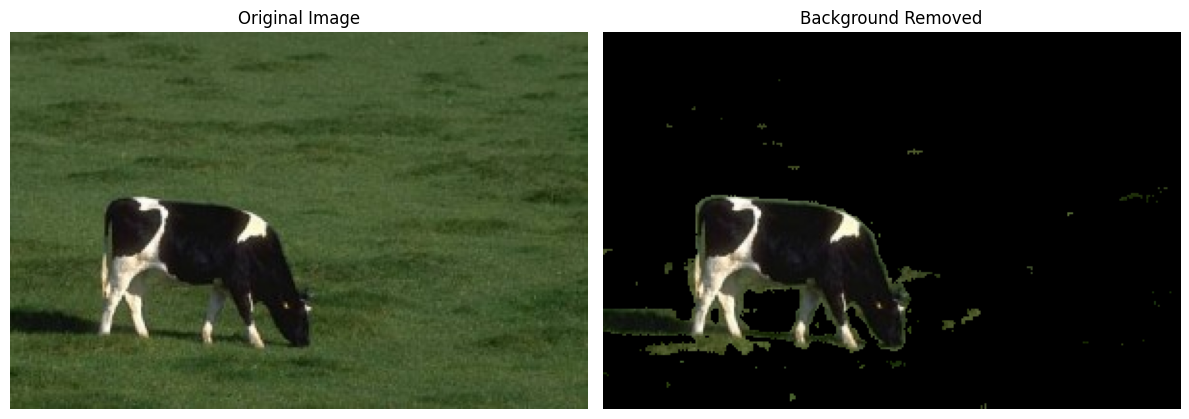

In [9]:
# Load the image
image_path = "cow.jpg"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)
h, w, c = image_np.shape

# Reshape image to a 2D array of pixels (each pixel is a 3D RGB vector)
X = image_np.reshape(-1, 3).astype(np.float64)

# Apply GMM with 3 components (assume grass + 2 parts of cow)
gmm = GMM(n_components=3)
gmm.fit(X)

# Predict labels
labels = gmm.predict(X)

# Assume the background is the most common cluster
bg_label = np.bincount(labels).argmax()
mask = labels != bg_label

# Apply the mask to black out the background
result = X.copy()
result[~mask] = [0, 0, 0]  # set background pixels to black
result_image = result.reshape(h, w, 3).astype(np.uint8)

# Display the original and the result
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(result_image)
axs[1].set_title("Background Removed")
axs[1].axis("off")

plt.tight_layout()
plt.show()